In [1]:
# force the notebook to auto reload external python modules | useful for development
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import sys

sys.path.append("..\\")
from src.data import MyDataset, AudioTripletDataset, LandmarkTripletDataset, AudioLandmarkTripletDataset
from src.features import TripletGenerator
# from src.models import main

import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader

random_seed = 42

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz-12.1.2-win64\\bin'

In [4]:
# paths
raw_data_path = "..\\data\\raw\\"
processed_data_path = "..\\data\\processed\\"

---

In [5]:
my_dataset = MyDataset(location=raw_data_path)

In [ ]:
# create & pickle dataset | RUN THIS CELL ONLY ONCE TO CREATE THE DATASET
my_dataset.create_dataset()
my_dataset.save_dataset(processed_data_path)

In [6]:
# load dataset | RUN THIS CELL TO LOAD THE SAVED DATASET
my_dataset.load_dataset(processed_data_path)
sample_size = len(my_dataset)
print(f"Loaded dataset with {sample_size} samples.")

Loaded dataset with 323 samples.


In [ ]:
# train-valid-test split
# to maintain independence between train and test sets, split the dataset before creating the triplets

train_size = int(0.6 * sample_size)
val_size = int(0.2 * sample_size)
test_size = sample_size - train_size - val_size

train_set, val_set, test_set = random_split(my_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(random_seed))

train_size, valid_size, test_size = len(train_set), len(val_set), len(test_set)
print(f"Train dataset size: {train_size} \nValid dataset size: {valid_size} \nTest dataset size: {test_size}")

In [7]:
# For Stratified Split

from sklearn.model_selection import train_test_split

# Assuming my_dataset is an instance of a Dataset class
sample_size = len(my_dataset)
targets = [my_dataset[i][1] for i in range(sample_size)]  # Assuming the second element is the label

# Splitting the data into train, validation, and test with stratification
train_idx, temp_idx, train_targets, temp_targets = train_test_split(
    range(sample_size), targets, test_size=0.2, stratify=targets, random_state=random_seed
)

val_idx, test_idx, val_targets, test_targets = train_test_split(
    temp_idx, temp_targets, test_size=0.2, stratify=temp_targets, random_state=random_seed
)

# Creating subsets
train_set = torch.utils.data.Subset(my_dataset, train_idx)
val_set = torch.utils.data.Subset(my_dataset, val_idx)
test_set = torch.utils.data.Subset(my_dataset, test_idx)

# Sizes of the datasets
train_size, valid_size, test_size = len(train_set), len(val_set), len(test_set)
print(f"Train dataset size: {train_size} \nValid dataset size: {valid_size} \nTest dataset size: {test_size}")


Train dataset size: 258 
Valid dataset size: 52 
Test dataset size: 13


In [8]:
# CREATE & PICKLE triplets of indicies | RUN THIS CELL ONLY ONCE TO CREATE THE TRIPLETS
# ensure diversity of triplets by setting num_triplets to a large number
# essentially 10 to 20 triplets per sample

num_triplets = 20

# TRAIN
train_triplets = TripletGenerator(train_set, num_triplets=train_size*num_triplets, prefix="train")
train_triplets.save_triplets(processed_data_path)

# VALID
valid_triplets = TripletGenerator(val_set, num_triplets=valid_size*num_triplets, prefix="valid")
valid_triplets.save_triplets(processed_data_path)

# TEST
test_triplets = TripletGenerator(test_set, num_triplets=test_size*num_triplets, prefix="test")
test_triplets.save_triplets(processed_data_path)

print(f"Created and saved: \
      \n {len(train_triplets.triplets)} train triplets \
      \n {len(valid_triplets.triplets)} valid triplets \
      \n {len(test_triplets.triplets)} test triplets"
      )

Created and saved:       
 5160 train triplets       
 1040 valid triplets       
 260 test triplets


---

In [9]:
# LOAD triplets | RUN THIS CELL TO LOAD THE SAVED TRIPLETS

# TRAIN
train_triplets = TripletGenerator(load=True, root_path=processed_data_path, prefix="train")
train_AL_triplets_dataset = AudioLandmarkTripletDataset(my_dataset.data, train_triplets.triplets)
train_audio_triplet_dataset = AudioTripletDataset(my_dataset.data, train_triplets.triplets)
train_landmark_triplet_dataset = LandmarkTripletDataset(my_dataset.data, train_triplets.triplets)

# VALID
valid_triplets = TripletGenerator(load=True, root_path=processed_data_path, prefix="valid")
valid_AL_triplets_dataset = AudioLandmarkTripletDataset(my_dataset.data, valid_triplets.triplets)
valid_audio_triplet_dataset = AudioTripletDataset(my_dataset.data, valid_triplets.triplets)
valid_landmark_triplet_dataset = LandmarkTripletDataset(my_dataset.data, valid_triplets.triplets)

# TEST
test_triplets = TripletGenerator(load=True, root_path=processed_data_path, prefix="test")
test_AL_triplets_dataset = AudioLandmarkTripletDataset(my_dataset.data, test_triplets.triplets)
test_audio_triplet_dataset = AudioTripletDataset(my_dataset.data, test_triplets.triplets)
test_landmark_triplet_dataset = LandmarkTripletDataset(my_dataset.data, test_triplets.triplets)

print(f"Loaded: \
      \n {len(train_triplets.triplets)} train triplets \
      \n {len(valid_triplets.triplets)} valid triplets \
      \n {len(test_triplets.triplets)} test triplets"
      )

Loaded:       
 5160 train triplets       
 1040 valid triplets       
 260 test triplets


In [10]:
# imports
from src.config import SystemConfig, TrainingConfig
from src.logging import setup_log_directory
from src.models import main
from src.visualization import plot_loss_accuracy

# logging
from torch.utils.tensorboard import SummaryWriter

# model summary & graph
from torchinfo import summary
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')

'svg'

In [12]:
def train_model(
        train_dataset: MyDataset, 
        valid_dataset: MyDataset, 
        model: torch.nn.Module,
        model_name: str
    ):
    
    # create dataloaders
    # Note to self: pin_mem for faster data transfer to GPU
    train_loader = DataLoader(
        train_dataset, 
        batch_size=TrainingConfig.batch_size, 
        shuffle=True, 
        pin_memory=True,
        num_workers=TrainingConfig.num_workers
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=TrainingConfig.batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=TrainingConfig.num_workers
    )

    # Debugging: Print model summary
    # print("Model structure:")
    # print(model)
    model.to(TrainingConfig.device)
    print(summary(model, input_size=(TrainingConfig.batch_size, 250, 3, 20))) # needs input shape?
    model_graph = draw_graph(model, input_size=(TrainingConfig.batch_size, 250, 3, 20), expand_nested=True)
    model_graph.visual_graph.render(f"..\\output\\figures\\{model_name}_model_graph", format="png")
                             

    training_config = TrainingConfig()

    # Model checkpoint log dir setup.
    training_config, current_version_name = setup_log_directory(training_config)

    # Tensorboard log dir setup.
    summary_writer = SummaryWriter(training_config.log_dir)

    # Train and Validate
    train_loss, train_acc, val_loss, val_acc = main(
        model,
        (train_loader, valid_loader),
        summary_writer=summary_writer,
        scheduler=None,
        system_config=SystemConfig(),
        training_config=training_config,
        data_augmentation=False,
        model_name=model_name,
    )
    
    return train_loss, train_acc, val_loss, val_acc
    

### Audio model

In [13]:
# importing models from src.models for experimentation
from src.models import LSTM, LSTM_II, LSTM_III, CNN

# MODEL TO USE
init_model = LSTM_III

In [14]:
audio_data_shape=(250, 400)
model = init_model(input_shape=audio_data_shape)
train_loss, train_acc, val_loss, val_acc = train_model(
    train_audio_triplet_dataset, 
    valid_audio_triplet_dataset, 
    model,
    "audio_model.pt"
)

Layer (type:depth-idx)                   Output Shape              Param #
LSTM_III                                 [32, 32]                  --
├─LSTM: 1-1                              [32, 250, 64]             119,296
├─BatchNorm1d: 1-2                       [32, 250, 64]             500
├─Flatten: 1-3                           [32, 16000]               --
├─Linear: 1-4                            [32, 128]                 2,048,128
├─BatchNorm1d: 1-5                       [32, 128]                 256
├─Linear: 1-6                            [32, 64]                  8,256
├─BatchNorm1d: 1-7                       [32, 64]                  128
├─Linear: 1-8                            [32, 32]                  2,080
Total params: 2,178,644
Trainable params: 2,178,644
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.02
Input size (MB): 12.80
Forward/backward pass size (MB): 8.30
Params size (MB): 8.71
Estimated Total Size (MB): 29.81



(process:27048): Pango-WARNING **: 03:11:55.530: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


Logging at: ..\output\Logs_Checkpoints\Model_logs\version_44
Model Checkpoint at: ..\output\Logs_Checkpoints\Model_checkpoints\version_44


Train:	Epoch: 1/20 Train Loss: 1.0000, Train Acc: 0.5099: 100%|██████████| 162/162 [02:20<00:00,  1.15it/s]
Valid:	Epoch: 1/20 Valid Loss: 1.0000, Valid Acc: 0.5293: 100%|██████████| 33/33 [01:57<00:00,  3.56s/it]



Model Improved... Saving Model ... Done.




Train:	Epoch: 2/20 Train Loss: 0.7685, Train Acc: 0.6139: 100%|██████████| 162/162 [01:11<00:00,  2.27it/s]
Valid:	Epoch: 2/20 Valid Loss: 1.0000, Valid Acc: 0.5369: 100%|██████████| 33/33 [00:14<00:00,  2.25it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 0/20 Train Loss: 0.5928, Train Acc: 0.7160: 100%|██████████| 162/162 [01:00<00:00,  2.69it/s]
Valid:	Epoch: 0/20 Valid Loss: 1.0000, Valid Acc: 0.5735: 100%|██████████| 33/33 [00:14<00:00,  2.22it/s]


Train:	Epoch: 4/20 Train Loss: 0.4629, Train Acc: 0.7975: 100%|██████████| 162/162 [01:00<00:00,  2.69it/s]
Valid:	Epoch: 4/20 Valid Loss: 0.9759, Valid Acc: 0.5665: 100%|██████████| 33/33 [00:14<00:00,  2.22it/s]


Train:	Epoch: 5/20 Train Loss: 0.3563, Train Acc: 0.8098: 100%|██████████| 162/162 [01:00<00:00,  2.66it/s]
Valid:	Epoch: 5/20 Valid Loss: 0.8696, Valid Acc: 0.6009: 100%|██████████| 33/33 [00:14<00:00,  2.20it/s]


Train:	Epoch: 6/20 Train Loss: 0.2936, Train Acc: 0.8449: 100%|██████████| 162/162 [01:00<00:00,  2.68it/s]
Valid:	Epoch: 6/20 Valid Loss: 0.7813, Valid Acc: 0.6265: 100%|██████████| 33/33 [00:15<00:00,  2.14it/s]


Train:	Epoch: 7/20 Train Loss: 0.2442, Train Acc: 0.9072: 100%|██████████| 162/162 [01:01<00:00,  2.64it/s]
Valid:	Epoch: 7/20 Valid Loss: 0.6976, Valid Acc: 0.6105: 100%|██████████| 33/33 [00:16<00:00,  1.98it/s]


Train:	Epoch: 8/20 Train Loss: 0.2208, Train Acc: 0.9102: 100%|██████████| 162/162 [01:05<00:00,  2.49it/s]
Valid:	Epoch: 8/20 Valid Loss: 0.6570, Valid Acc: 0.6479: 100%|██████████| 33/33 [00:15<00:00,  2.07it/s]


Train:	Epoch: 9/20 Train Loss: 0.1851, Train Acc: 0.8998: 100%|██████████| 162/162 [01:03<00:00,  2.54it/s]
Valid:	Epoch: 9/20 Valid Loss: 0.6125, Valid Acc: 0.6335: 100%|██████████| 33/33 [00:15<00:00,  2.07it/s]


Train:	Epoch: 10/20 Train Loss: 0.1429, Train Acc: 0.9306: 100%|██████████| 162/162 [01:04<00:00,  2.50it/s]
Valid:	Epoch: 10/20 Valid Loss: 0.5742, Valid Acc: 0.6434: 100%|██████████| 33/33 [00:19<00:00,  1.68it/s]


Train:	Epoch: 11/20 Train Loss: 0.1480, Train Acc: 0.9183: 100%|██████████| 162/162 [01:03<00:00,  2.56it/s]
Valid:	Epoch: 11/20 Valid Loss: 0.5634, Valid Acc: 0.6400: 100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


Train:	Epoch: 12/20 Train Loss: 0.1293, Train Acc: 0.9241: 100%|██████████| 162/162 [01:07<00:00,  2.41it/s]
Valid:	Epoch: 12/20 Valid Loss: 0.5596, Valid Acc: 0.6600: 100%|██████████| 33/33 [00:19<00:00,  1.71it/s]


Train:	Epoch: 13/20 Train Loss: 0.1178, Train Acc: 0.9425: 100%|██████████| 162/162 [01:03<00:00,  2.55it/s]
Valid:	Epoch: 13/20 Valid Loss: 0.5324, Valid Acc: 0.6554: 100%|██████████| 33/33 [00:17<00:00,  1.94it/s]


Train:	Epoch: 14/20 Train Loss: 0.1243, Train Acc: 0.9026: 100%|██████████| 162/162 [01:03<00:00,  2.55it/s]
Valid:	Epoch: 14/20 Valid Loss: 0.5399, Valid Acc: 0.6356: 100%|██████████| 33/33 [00:17<00:00,  1.91it/s]


Train:	Epoch: 15/20 Train Loss: 0.1238, Train Acc: 0.9088: 100%|██████████| 162/162 [01:01<00:00,  2.64it/s]
Valid:	Epoch: 15/20 Valid Loss: 0.4918, Valid Acc: 0.6600: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]


Train:	Epoch: 16/20 Train Loss: 0.1193, Train Acc: 0.9338: 100%|██████████| 162/162 [01:02<00:00,  2.60it/s]
Valid:	Epoch: 16/20 Valid Loss: 0.5215, Valid Acc: 0.6338: 100%|██████████| 33/33 [00:16<00:00,  1.95it/s]


Train:	Epoch: 17/20 Train Loss: 0.0990, Train Acc: 0.9260: 100%|██████████| 162/162 [01:04<00:00,  2.49it/s]
Valid:	Epoch: 17/20 Valid Loss: 0.5107, Valid Acc: 0.6600: 100%|██████████| 33/33 [00:22<00:00,  1.44it/s]


Train:	Epoch: 18/20 Train Loss: 0.1024, Train Acc: 0.9535: 100%|██████████| 162/162 [01:15<00:00,  2.15it/s]
Valid:	Epoch: 18/20 Valid Loss: 0.5043, Valid Acc: 0.6198: 100%|██████████| 33/33 [00:59<00:00,  1.80s/it]


Train:	Epoch: 19/20 Train Loss: 0.1074, Train Acc: 0.9298: 100%|██████████| 162/162 [01:02<00:00,  2.61it/s]
Valid:	Epoch: 19/20 Valid Loss: 0.5063, Valid Acc: 0.6327: 100%|██████████| 33/33 [00:28<00:00,  1.14it/s]


Train:	Epoch: 20/20 Train Loss: 0.1128, Train Acc: 0.9202: 100%|██████████| 162/162 [01:03<00:00,  2.54it/s]
Valid:	Epoch: 20/20 Valid Loss: 0.4841, Valid Acc: 0.6600: 100%|██████████| 33/33 [00:18<00:00,  1.77it/s]



Model Improved... Saving Model ... Done.


Total time: 1855.31s, Best Loss: 0.4841


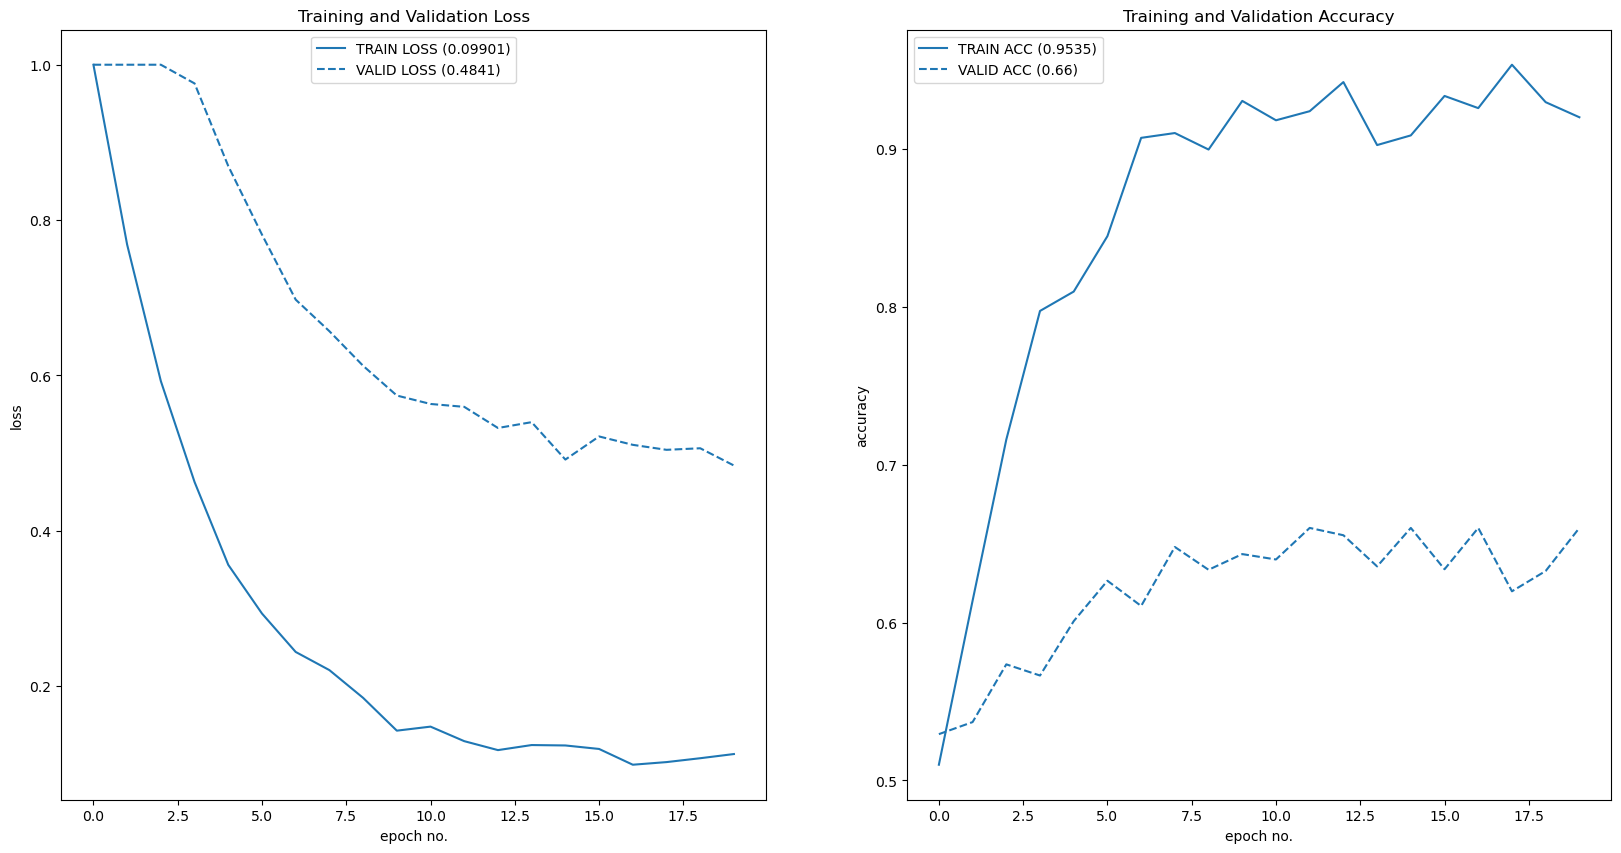

In [15]:
# plot loss and accuracy
plot_loss_accuracy(
    train_loss=[train_loss],
    val_loss=[val_loss],
    train_acc=[train_acc],
    val_acc=[val_acc],
    colors=["blue"],
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
)

### Landmark Model

In [16]:
from src.models import STGCN

In [17]:
model_l = STGCN(num_nodes=20, in_channels=250, out_channels=64, num_frames=250)
train_loss, train_acc, val_loss, val_acc = train_model(
    train_landmark_triplet_dataset, 
    valid_landmark_triplet_dataset, 
    model_l,
    "landmark_model.pt"
)

Layer (type:depth-idx)                   Output Shape              Param #
STGCN                                    [32, 64, 1, 20]           --
├─Conv2d: 1-1                            [32, 64, 1, 20]           48,064
├─GraphConvLayer: 1-2                    [32, 20, 32]              --
│    └─Linear: 2-1                       [32, 20, 32]              2,080
├─Conv2d: 1-3                            [32, 64, 1, 20]           6,208
Total params: 56,352
Trainable params: 56,352
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 34.80
Input size (MB): 1.92
Forward/backward pass size (MB): 0.82
Params size (MB): 0.23
Estimated Total Size (MB): 2.96



(process:17280): Pango-WARNING **: 04:28:38.908: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


Logging at: ..\output\Logs_Checkpoints\Model_logs\version_45
Model Checkpoint at: ..\output\Logs_Checkpoints\Model_checkpoints\version_45


Train:	Epoch: 1/20 Train Loss: 0.9942, Train Acc: 0.5062: 100%|██████████| 162/162 [06:45<00:00,  2.50s/it]  
Valid:	Epoch: 1/20 Valid Loss: 1.5000, Valid Acc: 0.4332: 100%|██████████| 33/33 [00:41<00:00,  1.26s/it]



Model Improved... Saving Model ... Done.




Train:	Epoch: 2/20 Train Loss: 0.7680, Train Acc: 0.5928: 100%|██████████| 162/162 [00:19<00:00,  8.17it/s]
Valid:	Epoch: 2/20 Valid Loss: 1.2756, Valid Acc: 0.4988: 100%|██████████| 33/33 [00:14<00:00,  2.23it/s]


Train:	Epoch: 3/20 Train Loss: 0.6195, Train Acc: 0.6941: 100%|██████████| 162/162 [00:21<00:00,  7.52it/s]
Valid:	Epoch: 3/20 Valid Loss: 1.0624, Valid Acc: 0.5523: 100%|██████████| 33/33 [00:16<00:00,  1.99it/s]


Train:	Epoch: 4/20 Train Loss: 0.4650, Train Acc: 0.8056: 100%|██████████| 162/162 [00:16<00:00,  9.79it/s]
Valid:	Epoch: 4/20 Valid Loss: 0.8940, Valid Acc: 0.5951: 100%|██████████| 33/33 [00:25<00:00,  1.28it/s]


Train:	Epoch: 5/20 Train Loss: 0.3826, Train Acc: 0.8458: 100%|██████████| 162/162 [00:17<00:00,  9.02it/s]
Valid:	Epoch: 5/20 Valid Loss: 0.7670, Valid Acc: 0.6271: 100%|██████████| 33/33 [00:17<00:00,  1.88it/s]


Train:	Epoch: 6/20 Train Loss: 0.2938, Train Acc: 0.8770: 100%|██████████| 162/162 [00:18<00:00,  8.87it/s]
Valid:	Epoch: 6/20 Valid Loss: 0.6786, Valid Acc: 0.6186: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s]


Train:	Epoch: 7/20 Train Loss: 0.2484, Train Acc: 0.9094: 100%|██████████| 162/162 [00:14<00:00, 11.04it/s]
Valid:	Epoch: 7/20 Valid Loss: 0.6067, Valid Acc: 0.6490: 100%|██████████| 33/33 [00:14<00:00,  2.35it/s]


Train:	Epoch: 8/20 Train Loss: 0.2279, Train Acc: 0.9369: 100%|██████████| 162/162 [00:15<00:00, 10.24it/s]
Valid:	Epoch: 8/20 Valid Loss: 0.5515, Valid Acc: 0.6392: 100%|██████████| 33/33 [00:12<00:00,  2.65it/s]


Train:	Epoch: 9/20 Train Loss: 0.1754, Train Acc: 0.9348: 100%|██████████| 162/162 [00:16<00:00,  9.85it/s]
Valid:	Epoch: 9/20 Valid Loss: 0.5082, Valid Acc: 0.6487: 100%|██████████| 33/33 [00:12<00:00,  2.65it/s]


Train:	Epoch: 10/20 Train Loss: 0.1786, Train Acc: 0.9415: 100%|██████████| 162/162 [01:43<00:00,  1.56it/s]
Valid:	Epoch: 10/20 Valid Loss: 0.4640, Valid Acc: 0.6378: 100%|██████████| 33/33 [00:14<00:00,  2.29it/s]


Train:	Epoch: 11/20 Train Loss: 0.1519, Train Acc: 0.9695: 100%|██████████| 162/162 [00:16<00:00,  9.85it/s]
Valid:	Epoch: 11/20 Valid Loss: 0.4640, Valid Acc: 0.6511: 100%|██████████| 33/33 [00:14<00:00,  2.25it/s]


Train:	Epoch: 12/20 Train Loss: 0.1276, Train Acc: 0.9524: 100%|██████████| 162/162 [00:14<00:00, 10.84it/s]
Valid:	Epoch: 12/20 Valid Loss: 0.4463, Valid Acc: 0.6452: 100%|██████████| 33/33 [00:13<00:00,  2.46it/s]


Train:	Epoch: 13/20 Train Loss: 0.1309, Train Acc: 0.9848: 100%|██████████| 162/162 [00:14<00:00, 11.18it/s]
Valid:	Epoch: 13/20 Valid Loss: 0.4355, Valid Acc: 0.6547: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s]


Train:	Epoch: 14/20 Train Loss: 0.1279, Train Acc: 0.9460: 100%|██████████| 162/162 [00:13<00:00, 11.91it/s]
Valid:	Epoch: 14/20 Valid Loss: 0.4115, Valid Acc: 0.6968: 100%|██████████| 33/33 [00:12<00:00,  2.61it/s]


Train:	Epoch: 15/20 Train Loss: 0.1197, Train Acc: 1.0000: 100%|██████████| 162/162 [00:19<00:00,  8.47it/s]
Valid:	Epoch: 15/20 Valid Loss: 0.4072, Valid Acc: 0.6579: 100%|██████████| 33/33 [00:15<00:00,  2.12it/s]


Train:	Epoch: 16/20 Train Loss: 0.0943, Train Acc: 0.9940: 100%|██████████| 162/162 [00:18<00:00,  8.93it/s]
Valid:	Epoch: 16/20 Valid Loss: 0.4239, Valid Acc: 0.7306: 100%|██████████| 33/33 [00:14<00:00,  2.31it/s]


Train:	Epoch: 17/20 Train Loss: 0.1001, Train Acc: 0.9911: 100%|██████████| 162/162 [00:16<00:00, 10.09it/s]
Valid:	Epoch: 17/20 Valid Loss: 0.4095, Valid Acc: 0.6881: 100%|██████████| 33/33 [00:12<00:00,  2.59it/s]


Train:	Epoch: 18/20 Train Loss: 0.1030, Train Acc: 1.0000: 100%|██████████| 162/162 [00:16<00:00,  9.75it/s]
Valid:	Epoch: 18/20 Valid Loss: 0.4141, Valid Acc: 0.6824: 100%|██████████| 33/33 [00:13<00:00,  2.52it/s]


Train:	Epoch: 19/20 Train Loss: 0.1033, Train Acc: 1.0000: 100%|██████████| 162/162 [00:16<00:00, 10.08it/s]
Valid:	Epoch: 19/20 Valid Loss: 0.4057, Valid Acc: 0.6619: 100%|██████████| 33/33 [00:13<00:00,  2.43it/s]


Train:	Epoch: 20/20 Train Loss: 0.1092, Train Acc: 1.0000: 100%|██████████| 162/162 [00:15<00:00, 10.62it/s]
Valid:	Epoch: 20/20 Valid Loss: 0.4043, Valid Acc: 0.6933: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s]


Model Improved... Saving Model ... Done.


Total time: 1140.41s, Best Loss: .4043


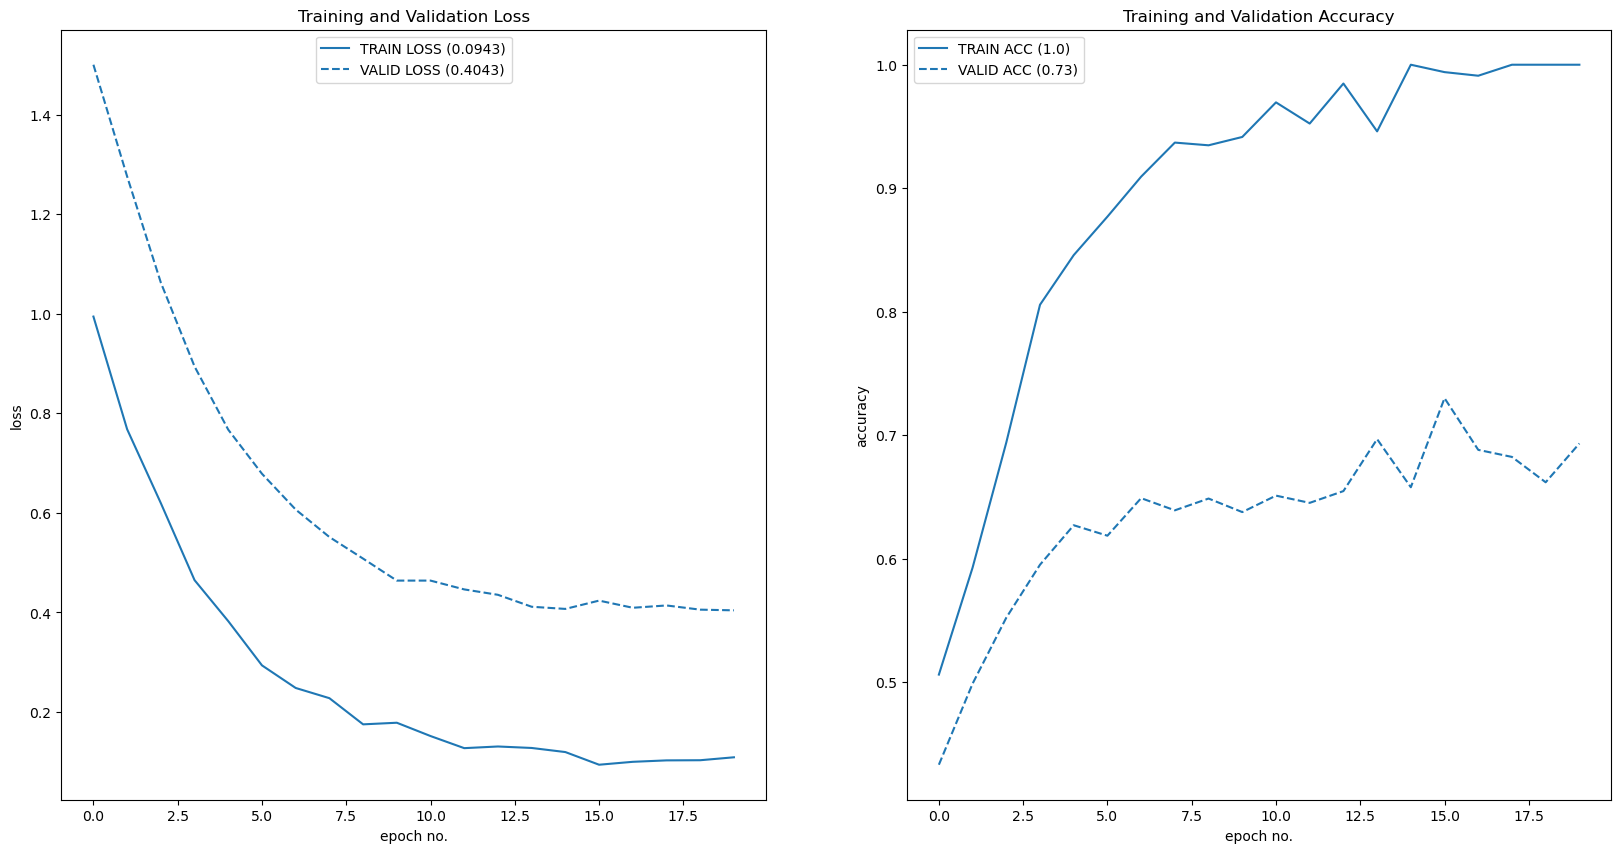

In [18]:
# plot loss and accuracy
plot_loss_accuracy(
    train_loss=[train_loss],
    val_loss=[val_loss],
    train_acc=[train_acc],
    val_acc=[val_acc],
    colors=["blue"],
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
)

### Combined model testing

In [19]:
# imports
from src.models import test, load_model

In [20]:
# load models
lstm = LSTM_III(input_shape=audio_data_shape)
stgcn = STGCN(num_nodes=20, in_channels=250, out_channels=64, num_frames=250)
audio_model = load_model(
    lstm,
    model_dir=TrainingConfig.root_checkpoint_dir,
    model_file_name="audio_model.pt",
    device=TrainingConfig.device
    )
landmark_model = load_model(
    stgcn,
    model_dir=TrainingConfig.root_checkpoint_dir,
    model_file_name="landmark_model.pt",
    device=TrainingConfig.device
    )

In [21]:
test(
    audio_model,
    landmark_model,
    test_AL_triplets_dataset,
    TrainingConfig
)

Accuracy on test set: 73.31
